In [ ]:
# Set seed for reproducibility
seed = 42

import random
from datetime import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.layers import Layer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
import cv2

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 🪨 Load and prepare data

In [ ]:
data = np.load("/kaggle/input/segmentation-dataset/clean_dataset_c2.npz")
X = data["images"]
y = data["labels"]

data = np.load("/kaggle/input/segmentation-dataset-mars/mars_for_students.npz")
X_test = data["test_set"]

Compute class weights

In [ ]:
# Flatten all labels to calculate the class distribution
flat_labels = y.flatten()

# Compute the unique classes and their respective frequencies
classes, class_counts = np.unique(flat_labels, return_counts=True)

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (2004, 64, 128)
Validation set shape: (501, 64, 128)
Test set shape: (10022, 64, 128)


In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


# ➕ Apply augmentations to training set

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=20, p=0.5),  # Random rotations within +/-20 degrees
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),  # Spatial distortions
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # Apply Gaussian blur
    A.GridDistortion(p=0.3),  # Grid distortions for texture variations
])

def augment_image_and_label(image, label, transform):
    augmented = transform(image=image, mask=label)
    return augmented['image'], augmented['mask']

In [ ]:
def data_generator(X, y, batch_size, transform):
    while True:
        # Randomly shuffle data
        indices = np.arange(len(X))
        np.random.shuffle(indices)

        for i in range(0, len(X), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_images = X[batch_indices]
            batch_labels = y[batch_indices]

            # Apply augmentations
            augmented_images = []
            augmented_labels = []
            for img, lbl in zip(batch_images, batch_labels):
                aug_img, aug_lbl = augment_image_and_label(img, lbl, transform)
                augmented_images.append(aug_img)
                augmented_labels.append(aug_lbl)

            yield np.array(augmented_images), np.array(augmented_labels)


# 🩱 Custom Layers

In [ ]:
# prompt: expand the 0 to 150 range to the 0 to 255 range

def stretch_histogram(image):
    # Find the minimum and maximum pixel values in the image
    min_val = np.min(image)
    max_val = np.max(image)

    # Calculate the scaling factor
    scale_factor = 255 / (max_val - min_val)

    # Stretch the histogram by scaling pixel values
    stretched_image = (image - min_val) * scale_factor

    # Clip the values to the range [0, 255]
    stretched_image = np.clip(stretched_image, 0, 255)

    # Convert to uint8 data type if needed
    stretched_image = stretched_image.astype(np.uint8)
    return stretched_image

In [ ]:
@register_keras_serializable(package='Custom', name='EdgeDetectionLayer')
class EdgeDetectionLayer(Layer):
    def __init__(self, **kwargs):
        super(EdgeDetectionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Espandi la dimensione per batch se necessario
        inputs_expanded = tf.expand_dims(inputs, axis=-1) if len(inputs.shape) == 3 else inputs

        # Applica il rilevamento dei bordi
        sobel_x = tf.image.sobel_edges(inputs_expanded)  # Calcola Sobel
        edges = tf.sqrt(tf.reduce_sum(tf.square(sobel_x), axis=-1))  # Calcola la magnitudine

        edges = edges / tf.reduce_max(edges)

        amplification_factor = 0.3
        image = tf.clip_by_value(inputs + amplification_factor * edges, 0.0, 1.0)

        #image = tf.squeeze(image, axis=0) #tolgo batch

        # Restituisce i bordi
        return image

In [ ]:
@register_keras_serializable(package='Custom', name='StretchHistogramLayer')
class StretchHistogramLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(StretchHistogramLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Calcola il valore minimo e massimo lungo i canali
        min_val = tf.reduce_min(inputs, axis=[1, 2], keepdims=True)
        max_val = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)

        # Calcola il fattore di scala
        scale_factor = 255.0 / (max_val - min_val + tf.keras.backend.epsilon())

        # Applica lo stretching
        stretched = (inputs - min_val) * scale_factor

        # Clippa i valori nel range [0, 255]
        stretched = tf.clip_by_value(stretched, 0.0, 255.0)

        return stretched


In [ ]:
@register_keras_serializable(package='Custom', name='GammaCorrectionLayer')
class GammaCorrectionLayer(Layer):
    def __init__(self, gamma=1.0, **kwargs):
        super(GammaCorrectionLayer, self).__init__(**kwargs)
        self.gamma = gamma

    def call(self, inputs):
        # Applica la correzione gamma
        corrected = tf.pow(inputs, self.gamma)
        # Riporta l'immagine nell'intervallo originale [0, 255]
        return corrected * 255.0

# 🎛️ Network parameters

In [ ]:
# Set batch size for training
batch_size = 64

# Set learning rate for the optimiser
learning_rate = 0.001

# Set early stopping patience threshold
patience = 20

# Set maximum number of training epochs
epochs = 200

# 🏗️ Build Unet model

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
# Dual U-Net combining the local and global U-Nets
def dual_unet(input_shape):
    # Single input for the entire network
    input_layer = tfkl.Input(input_shape, name='input')

    equalized_layer = StretchHistogramLayer()(input_layer)
    edge_layer = EdgeDetectionLayer()(equalized_layer)

    # Concatenate edge and equalized layers
    sum_layer = tfkl.Concatenate(name='concat_edge_equalized')([edge_layer, equalized_layer])

    # Edge encoder
    down_block_1 = unet_block(sum_layer, 32, name='edge_down_block1_')
    d1 = tfkl.MaxPooling2D(name='edge_pool1')(down_block_1)
    down_block_2 = unet_block(d1, 64, name='edge_down_block2_')
    d2 = tfkl.MaxPooling2D(name='edge_pool2')(down_block_2)
    down_block_3 = unet_block(d2, 128, name='edge_down_block3_')
    d3 = tfkl.MaxPooling2D(name='edge_pool3')(down_block_3)
    down_block_4 = unet_block(d3, 256, name='edge_down_block4_')
    d4 = tfkl.MaxPooling2D(name='edge_pool4')(down_block_4)
    bottleneck_1 = unet_block(d4, 512, name='edge_bottleneck1_')

    # Original encoder
    down_block_5 = unet_block(equalized_layer, 32, name='original_down_block1_')
    d5 = tfkl.MaxPooling2D(name='original_pool1')(down_block_5)
    down_block_6 = unet_block(d5, 64, name='original_down_block2_')
    d6 = tfkl.MaxPooling2D(name='original_pool2')(down_block_6)
    down_block_7 = unet_block(d6, 128, name='original_down_block3_')
    d7 = tfkl.MaxPooling2D(name='original_pool3')(down_block_7)
    down_block_8 = unet_block(d7, 256, name='original_down_block4_')
    d8 = tfkl.MaxPooling2D(name='original_pool4')(down_block_8)
    bottleneck_2 = unet_block(d8, 512, name='original_bottleneck2_')

    # Bottleneck concatenation
    bottleneck = tfkl.Concatenate(name='bottleneck_concat')([bottleneck_1, bottleneck_2])

    # Decoder
    up_block_1 = unet_block(bottleneck, 256, name='up_block1_')
    u1 = tfkl.UpSampling2D(name='upsample1')(up_block_1)
    u1 = tfkl.Concatenate(name='concat_up1')([u1, down_block_4, down_block_8])

    up_block_2 = unet_block(u1, 128, name='up_block2_')
    u2 = tfkl.UpSampling2D(name='upsample2')(up_block_2)
    u2 = tfkl.Concatenate(name='concat_up2')([u2, down_block_3, down_block_7])

    up_block_3 = unet_block(u2, 64, name='up_block3_')
    u3 = tfkl.UpSampling2D(name='upsample3')(up_block_3)
    u3 = tfkl.Concatenate(name='concat_up3')([u3, down_block_2, down_block_6])

    up_block_4 = unet_block(u3, 32, name='up_block4_')
    u4 = tfkl.UpSampling2D(name='upsample4')(up_block_4)
    u4 = tfkl.Concatenate(name='concat_up4')([u4, down_block_1, down_block_5])

    # Output layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    # Model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Dual_UNet')

    return model

In [ ]:
@tf.keras.saving.register_keras_serializable()
def weighted_sparse_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Gather the weights for the true class labels
        weights = tf.gather(class_weights, tf.cast(y_true, tf.int32))
        # Compute sparse categorical crossentropy
        scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        return scce * weights
    return loss

In [ ]:
@tf.keras.saving.register_keras_serializable()
def sparse_categorical_crossentropy_ignore_class(ignore_class):
    """
    Ritorna una funzione di perdita personalizzata che ignora una classe specifica.
    """
    def loss_fn(y_true, y_pred):
        # Crea una maschera: True dove y_true != ignore_class
        mask = tf.cast(tf.not_equal(y_true, ignore_class), tf.float32)

        # Applica SparseCategoricalCrossentropy
        scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
        loss = scce(y_true, y_pred)

        # Applica la maschera per ignorare la classe specifica
        loss = loss * mask

        # Calcola la media solo sulle classi valide
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    return loss_fn

Model: "Dual_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 64, 128,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stretch_histogram_… │ (None, 64, 128,   │          0 │ input[0][0]       │
│ (StretchHistogramL… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_detection_lay… │ (None, 64, 128,   │          0 │ stretch_histogra… │
│ (EdgeDetectionLaye… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_edge_equali… │ (None, 64, 128,   │          0 │ edge_detection_l… │
│ (Concatenate)       │ 2)                │            │ stretch_histogra… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_down_block1_c… │ (None, 64, 128,   │        608 │ concat_edge_equa… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ original_down_bloc… │ (None, 64, 128,   │        320 │ stretch_histogra… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_down_block1_b… │ (None, 64, 128,   │        128 │ edge_down_block1… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ original_down_bloc… │ (None, 64, 128,   │        128 │ original_down_bl… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_down_block1_a… │ (None, 64, 128,   │          0 │ edge_down_block1… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ original_down_bloc… │ (None, 64, 128,   │          0 │ original_down_bl… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_down_block1_c… │ (None, 64, 128,   │      9,248 │ edge_down_block1… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ original_down_bloc… │ (None, 64, 128,   │      9,248 │ original_down_bl… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_down_block1_b… │ (None, 64, 128,   │        128 │ edge_down_block1… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ original_down_bloc… │ (None, 64, 128,   │        128 │ original_down_bl… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_down_block1_a… │ (None, 64, 128,   │          0 │ edge_down_block1… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ original_down_bloc… │ (None, 64, 128,   │          0 │ original_down_bl… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_pool1          │ (None, 32, 64,    │          0 │ edge_down_block1

 Total params: 13,748,613 (52.45 MB)

 Trainable params: 13,738,757 (52.41 MB)

 Non-trainable params: 9,856 (38.50 KB)

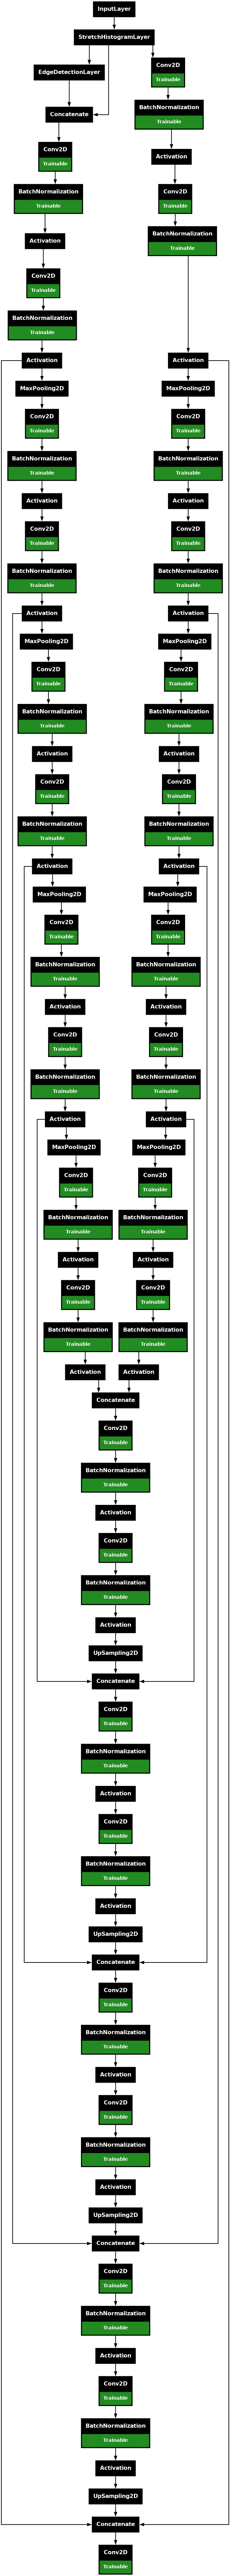

In [ ]:
# Build the dual U-Net model
model = dual_unet(input_shape)


# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)
ignore_class = 0
loss_fn = sparse_categorical_crossentropy_ignore_class(ignore_class)
model.compile(
    loss=loss_fn,
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=[mean_iou])

model.summary()

tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

# 🏋🏻 Train the model

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_io_u',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Dynamic learning rate
redurce_learning_rate = tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_io_u', factor=0.1, patience=10, min_delta=1e-4, min_lr=1e-5)

# prompt: create a visualization callback that shoows the validation image at index 0, its output and its expected output, every 5 epochs
def visualize_callback(epoch, logs):
    if epoch % 5 == 0:
        # Select a random validation image
        index = 3  # Use index 0 for the first validation image
        val_image = X_val[index]
        val_label = y_val[index]

        # Predict the output for the selected image
        predicted_output = model.predict(np.expand_dims(val_image, axis=0))
        predicted_class = np.argmax(predicted_output[0], axis=-1)

        # Plot the image, predicted output, and expected output
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(val_image[:, :, 0])
        plt.title(f"Validation Image (Index: {index})")

        plt.subplot(1, 3, 2)
        plt.imshow(predicted_class)
        plt.title("Predicted Output")

        plt.subplot(1, 3, 3)
        plt.imshow(val_label)
        plt.title("Expected Output")


        plt.show()

visualize = tfk.callbacks.LambdaCallback(on_epoch_end=visualize_callback)

Epoch 1/200


I0000 00:00:1734198230.245253      93 service.cc:145] XLA service 0x7f075c003b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734198230.245313      93 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734198230.245319      93 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1734198231.867302      93 assert_op.cc:38] Ignoring Assert operator compile_loss/loss_fn/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734198254.978054      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 1.1887 - mean_io_u: 0.2072

W0000 00:00:1734198262.783725      93 assert_op.cc:38] Ignoring Assert operator compile_loss/loss_fn/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734198264.357415      93 assert_op.cc:38] Ignoring Assert operator compile_loss/loss_fn/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


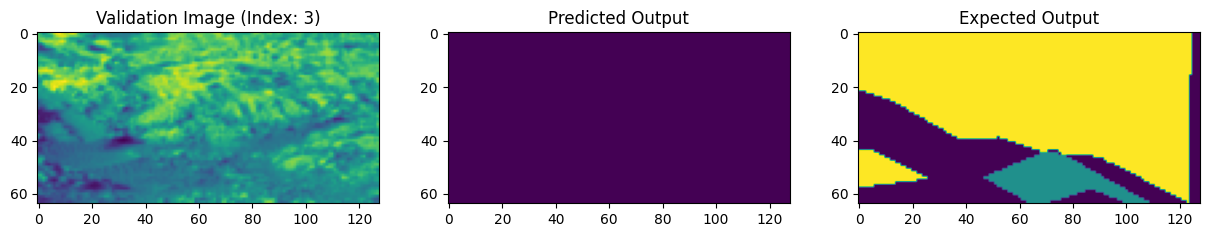

31/31 ━━━━━━━━━━━━━━━━━━━━ 57s 544ms/step - loss: 1.1831 - mean_io_u: 0.2085 - val_loss: 312.8560 - val_mean_io_u: 0.0689 - learning_rate: 0.0010
Epoch 2/200


W0000 00:00:1734198272.574962      96 assert_op.cc:38] Ignoring Assert operator compile_loss/loss_fn/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - loss: 0.8655 - mean_io_u: 0.3527 - val_loss: 80.7585 - val_mean_io_u: 0.0774 - learning_rate: 0.0010
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - loss: 0.7639 - mean_io_u: 0.3830 - val_loss: 38.2015 - val_mean_io_u: 0.1091 - learning_rate: 0.0010
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - loss: 0.6779 - mean_io_u: 0.4372 - val_loss: 27.7975 - val_mean_io_u: 0.1427 - learning_rate: 0.0010
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - loss: 0.6803 - mean_io_u: 0.4287 - val_loss: 4.6992 - val_mean_io_u: 0.1651 - learning_rate: 0.0010
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/steptep - loss: 0.6768 - mean_io_u: 0.426


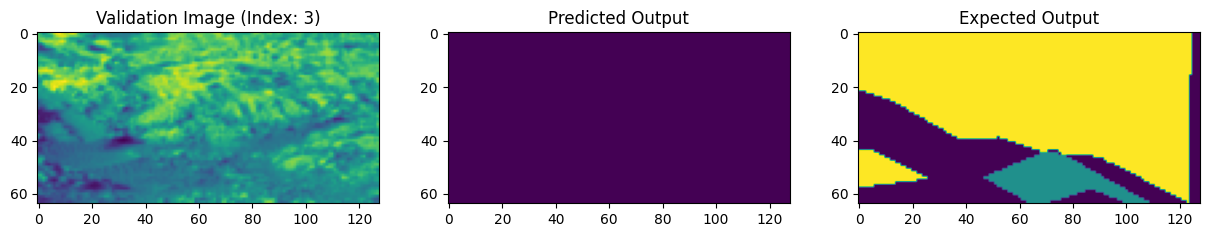

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.6766 - mean_io_u: 0.4270 - val_loss: 2.2725 - val_mean_io_u: 0.2362 - learning_rate: 0.0010
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - loss: 0.6240 - mean_io_u: 0.4626 - val_loss: 3.4896 - val_mean_io_u: 0.1025 - learning_rate: 0.0010
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - loss: 0.5538 - mean_io_u: 0.4856 - val_loss: 5.0440 - val_mean_io_u: 0.1063 - learning_rate: 0.0010
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - loss: 0.5920 - mean_io_u: 0.4655 - val_loss: 0.9288 - val_mean_io_u: 0.4167 - learning_rate: 0.0010
Epoch 10/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 0.4719 - mean_io_u: 0.5269 - val_loss: 1.8466 - val_mean_io_u: 0.2309 - learning_rate: 0.0010
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/steptep - loss: 0.5073 - mean_io_u: 0.493


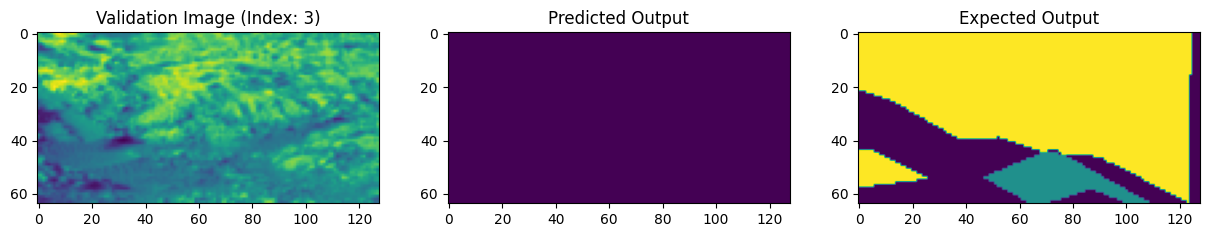

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - loss: 0.5082 - mean_io_u: 0.4932 - val_loss: 1.1143 - val_mean_io_u: 0.4746 - learning_rate: 0.0010
Epoch 12/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - loss: 0.4995 - mean_io_u: 0.5069 - val_loss: 0.6426 - val_mean_io_u: 0.4839 - learning_rate: 1.0000e-04
Epoch 13/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - loss: 0.4736 - mean_io_u: 0.5179 - val_loss: 0.4406 - val_mean_io_u: 0.5370 - learning_rate: 1.0000e-04
Epoch 14/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - loss: 0.4136 - mean_io_u: 0.5439 - val_loss: 0.4353 - val_mean_io_u: 0.5379 - learning_rate: 1.0000e-04
Epoch 15/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - loss: 0.4294 - mean_io_u: 0.5360 - val_loss: 0.4683 - val_mean_io_u: 0.5264 - learning_rate: 1.0000e-04
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 0.4095 - mean_io_u: 0.545


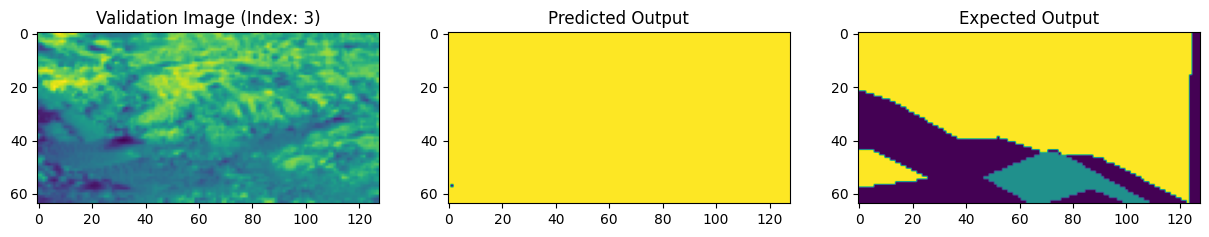

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - loss: 0.4095 - mean_io_u: 0.5451 - val_loss: 0.3969 - val_mean_io_u: 0.5596 - learning_rate: 1.0000e-04
Epoch 17/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - loss: 0.3976 - mean_io_u: 0.5477 - val_loss: 0.4566 - val_mean_io_u: 0.5316 - learning_rate: 1.0000e-04
Epoch 18/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - loss: 0.4097 - mean_io_u: 0.5484 - val_loss: 0.3713 - val_mean_io_u: 0.5604 - learning_rate: 1.0000e-04
Epoch 19/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - loss: 0.4215 - mean_io_u: 0.5391 - val_loss: 0.3767 - val_mean_io_u: 0.5607 - learning_rate: 1.0000e-04
Epoch 20/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - loss: 0.4107 - mean_io_u: 0.5360 - val_loss: 0.3541 - val_mean_io_u: 0.5745 - learning_rate: 1.0000e-04
Epoch 21/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/steptep - loss: 0.3845 - mean_io_u: 0.562


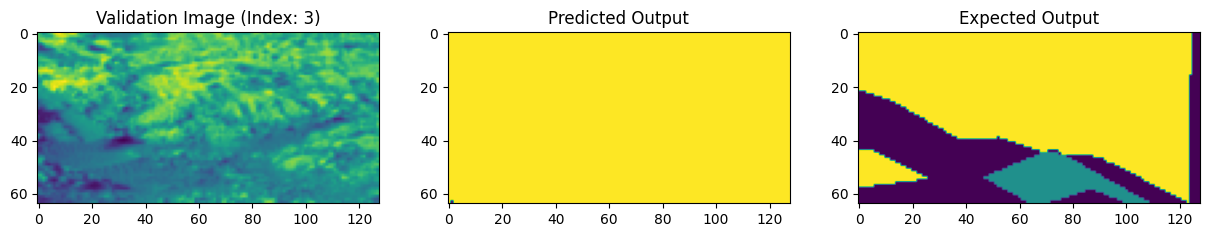

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - loss: 0.3843 - mean_io_u: 0.5624 - val_loss: 0.3840 - val_mean_io_u: 0.5547 - learning_rate: 1.0000e-04
Epoch 22/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - loss: 0.3754 - mean_io_u: 0.5640 - val_loss: 0.3659 - val_mean_io_u: 0.5648 - learning_rate: 1.0000e-05
Epoch 23/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - loss: 0.3638 - mean_io_u: 0.5691 - val_loss: 0.3588 - val_mean_io_u: 0.5707 - learning_rate: 1.0000e-05
Epoch 24/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.3584 - mean_io_u: 0.5687 - val_loss: 0.3521 - val_mean_io_u: 0.5746 - learning_rate: 1.0000e-05
Epoch 25/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 0.3599 - mean_io_u: 0.5719 - val_loss: 0.3519 - val_mean_io_u: 0.5750 - learning_rate: 1.0000e-05
Epoch 26/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 0.3667 - mean_io_u: 0.565


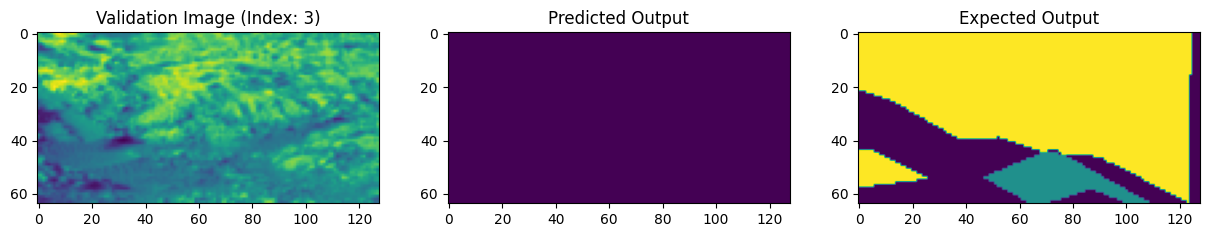

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - loss: 0.3665 - mean_io_u: 0.5652 - val_loss: 0.3479 - val_mean_io_u: 0.5758 - learning_rate: 1.0000e-05
Epoch 27/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 0.3706 - mean_io_u: 0.5628 - val_loss: 0.3463 - val_mean_io_u: 0.5766 - learning_rate: 1.0000e-05
Epoch 28/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 0.3775 - mean_io_u: 0.5796 - val_loss: 0.3438 - val_mean_io_u: 0.5786 - learning_rate: 1.0000e-05
Epoch 29/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 0.3540 - mean_io_u: 0.5759 - val_loss: 0.3419 - val_mean_io_u: 0.5804 - learning_rate: 1.0000e-05
Epoch 30/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - loss: 0.3743 - mean_io_u: 0.5663 - val_loss: 0.3418 - val_mean_io_u: 0.5813 - learning_rate: 1.0000e-05
Epoch 31/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/steptep - loss: 0.3605 - mean_io_u: 0.571


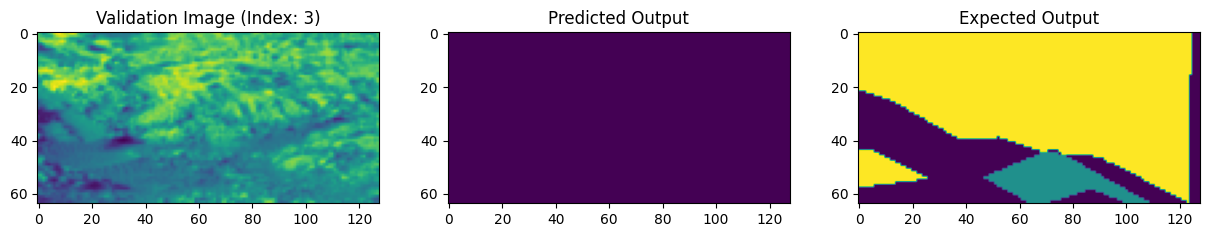

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - loss: 0.3606 - mean_io_u: 0.5711 - val_loss: 0.3436 - val_mean_io_u: 0.5811 - learning_rate: 1.0000e-05
Epoch 32/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - loss: 0.3538 - mean_io_u: 0.5817 - val_loss: 0.3482 - val_mean_io_u: 0.5776 - learning_rate: 1.0000e-05
Epoch 33/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3667 - mean_io_u: 0.5758 - val_loss: 0.3445 - val_mean_io_u: 0.5792 - learning_rate: 1.0000e-05
Epoch 34/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.3704 - mean_io_u: 0.5687 - val_loss: 0.3482 - val_mean_io_u: 0.5768 - learning_rate: 1.0000e-05
Epoch 35/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3579 - mean_io_u: 0.5728 - val_loss: 0.3473 - val_mean_io_u: 0.5776 - learning_rate: 1.0000e-05
Epoch 36/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 0.3326 - mean_io_u: 0.582


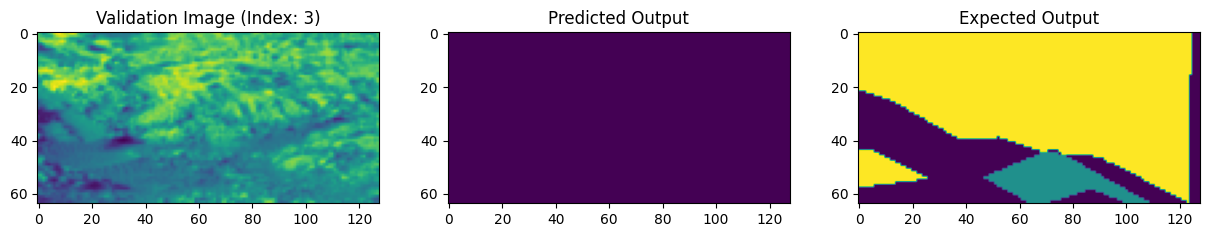

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - loss: 0.3332 - mean_io_u: 0.5824 - val_loss: 0.3409 - val_mean_io_u: 0.5810 - learning_rate: 1.0000e-05
Epoch 37/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - loss: 0.3870 - mean_io_u: 0.5526 - val_loss: 0.3392 - val_mean_io_u: 0.5836 - learning_rate: 1.0000e-05
Epoch 38/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - loss: 0.3519 - mean_io_u: 0.5756 - val_loss: 0.3370 - val_mean_io_u: 0.5841 - learning_rate: 1.0000e-05
Epoch 39/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3756 - mean_io_u: 0.5705 - val_loss: 0.3400 - val_mean_io_u: 0.5820 - learning_rate: 1.0000e-05
Epoch 40/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3490 - mean_io_u: 0.5720 - val_loss: 0.3408 - val_mean_io_u: 0.5810 - learning_rate: 1.0000e-05
Epoch 41/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 0.3702 - mean_io_u: 0.566


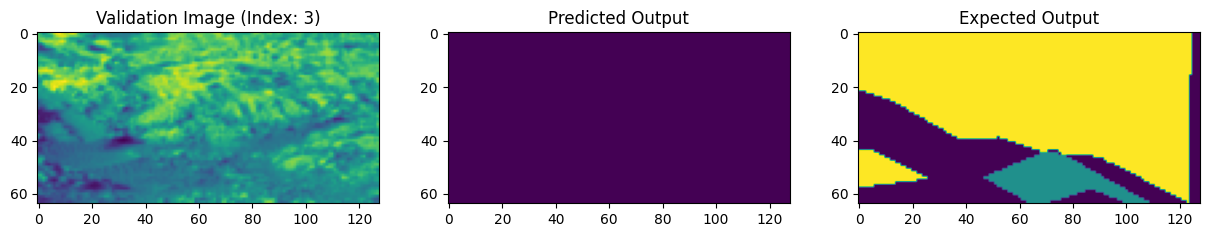

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - loss: 0.3703 - mean_io_u: 0.5664 - val_loss: 0.3376 - val_mean_io_u: 0.5834 - learning_rate: 1.0000e-05
Epoch 42/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3857 - mean_io_u: 0.5598 - val_loss: 0.3397 - val_mean_io_u: 0.5814 - learning_rate: 1.0000e-05
Epoch 43/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3551 - mean_io_u: 0.5930 - val_loss: 0.3441 - val_mean_io_u: 0.5800 - learning_rate: 1.0000e-05
Epoch 44/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3789 - mean_io_u: 0.5646 - val_loss: 0.3403 - val_mean_io_u: 0.5813 - learning_rate: 1.0000e-05
Epoch 45/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3659 - mean_io_u: 0.5704 - val_loss: 0.3354 - val_mean_io_u: 0.5826 - learning_rate: 1.0000e-05
Epoch 46/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/steptep - loss: 0.3775 - mean_io_u: 0.561


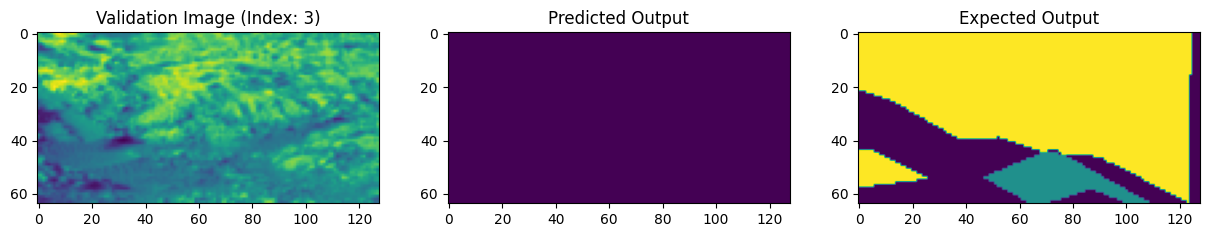

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - loss: 0.3772 - mean_io_u: 0.5619 - val_loss: 0.3369 - val_mean_io_u: 0.5818 - learning_rate: 1.0000e-05
Epoch 47/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3425 - mean_io_u: 0.5887 - val_loss: 0.3418 - val_mean_io_u: 0.5773 - learning_rate: 1.0000e-05
Epoch 48/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3329 - mean_io_u: 0.5858 - val_loss: 0.3363 - val_mean_io_u: 0.5826 - learning_rate: 1.0000e-05
Epoch 49/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3539 - mean_io_u: 0.5689 - val_loss: 0.3385 - val_mean_io_u: 0.5822 - learning_rate: 1.0000e-05
Epoch 50/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 0.3760 - mean_io_u: 0.5688 - val_loss: 0.3433 - val_mean_io_u: 0.5801 - learning_rate: 1.0000e-05
Epoch 51/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 0.3391 - mean_io_u: 0.579


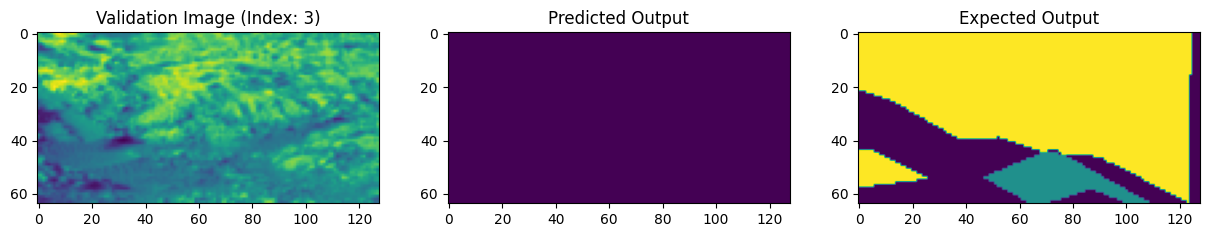

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - loss: 0.3394 - mean_io_u: 0.5792 - val_loss: 0.3404 - val_mean_io_u: 0.5820 - learning_rate: 1.0000e-05
Epoch 52/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3528 - mean_io_u: 0.5694 - val_loss: 0.3394 - val_mean_io_u: 0.5820 - learning_rate: 1.0000e-05
Epoch 53/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 0.3392 - mean_io_u: 0.5804 - val_loss: 0.3419 - val_mean_io_u: 0.5813 - learning_rate: 1.0000e-05
Epoch 54/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3461 - mean_io_u: 0.5774 - val_loss: 0.3397 - val_mean_io_u: 0.5812 - learning_rate: 1.0000e-05
Epoch 55/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3560 - mean_io_u: 0.5687 - val_loss: 0.3371 - val_mean_io_u: 0.5824 - learning_rate: 1.0000e-05
Epoch 56/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/steptep - loss: 0.3733 - mean_io_u: 0.564


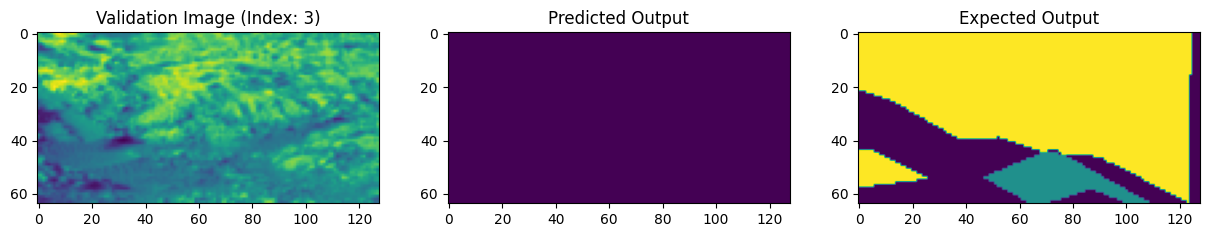

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - loss: 0.3729 - mean_io_u: 0.5645 - val_loss: 0.3357 - val_mean_io_u: 0.5823 - learning_rate: 1.0000e-05
Epoch 57/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 0.3592 - mean_io_u: 0.5749 - val_loss: 0.3324 - val_mean_io_u: 0.5846 - learning_rate: 1.0000e-05
Epoch 58/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.3615 - mean_io_u: 0.5722 - val_loss: 0.3379 - val_mean_io_u: 0.5806 - learning_rate: 1.0000e-05
Epoch 59/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3488 - mean_io_u: 0.5823 - val_loss: 0.3356 - val_mean_io_u: 0.5823 - learning_rate: 1.0000e-05
Epoch 60/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3357 - mean_io_u: 0.5873 - val_loss: 0.3351 - val_mean_io_u: 0.5845 - learning_rate: 1.0000e-05
Epoch 61/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/steptep - loss: 0.3475 - mean_io_u: 0.575


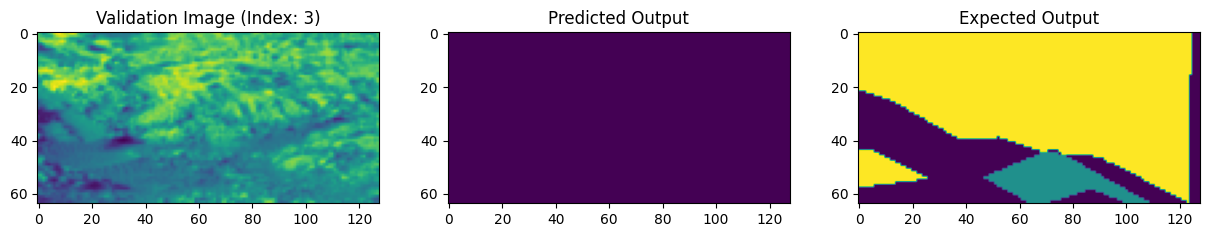

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - loss: 0.3480 - mean_io_u: 0.5756 - val_loss: 0.3333 - val_mean_io_u: 0.5846 - learning_rate: 1.0000e-05
Epoch 62/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3462 - mean_io_u: 0.5815 - val_loss: 0.3339 - val_mean_io_u: 0.5829 - learning_rate: 1.0000e-05
Epoch 63/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3359 - mean_io_u: 0.5797 - val_loss: 0.3357 - val_mean_io_u: 0.5797 - learning_rate: 1.0000e-05
Epoch 64/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3424 - mean_io_u: 0.5812 - val_loss: 0.3325 - val_mean_io_u: 0.5823 - learning_rate: 1.0000e-05
Epoch 65/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - loss: 0.3588 - mean_io_u: 0.5761 - val_loss: 0.3328 - val_mean_io_u: 0.5846 - learning_rate: 1.0000e-05
Epoch 66/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/steptep - loss: 0.3376 - mean_io_u: 0.594


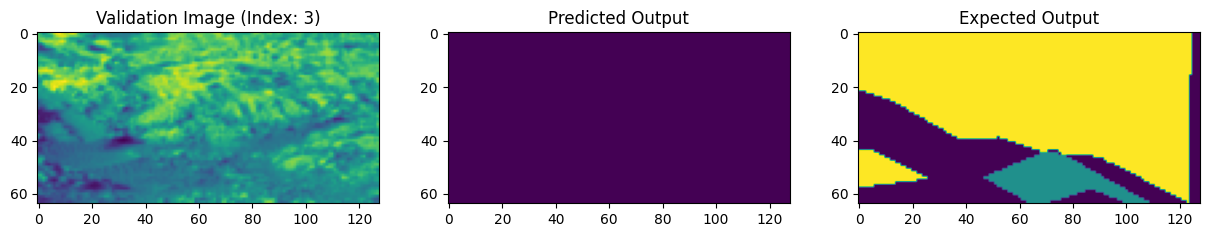

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - loss: 0.3379 - mean_io_u: 0.5937 - val_loss: 0.3355 - val_mean_io_u: 0.5823 - learning_rate: 1.0000e-05
Epoch 67/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3318 - mean_io_u: 0.5827 - val_loss: 0.3327 - val_mean_io_u: 0.5834 - learning_rate: 1.0000e-05
Epoch 68/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3486 - mean_io_u: 0.5781 - val_loss: 0.3357 - val_mean_io_u: 0.5819 - learning_rate: 1.0000e-05
Epoch 69/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - loss: 0.3385 - mean_io_u: 0.5790 - val_loss: 0.3370 - val_mean_io_u: 0.5812 - learning_rate: 1.0000e-05
Epoch 70/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3302 - mean_io_u: 0.5876 - val_loss: 0.3338 - val_mean_io_u: 0.5836 - learning_rate: 1.0000e-05
Epoch 71/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/steptep - loss: 0.3325 - mean_io_u: 0.581


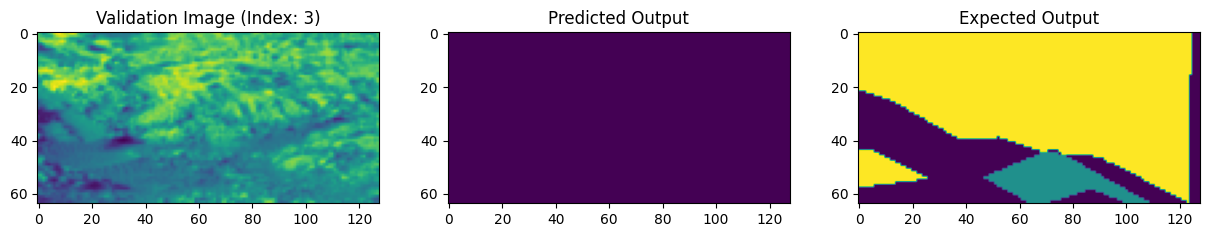

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - loss: 0.3326 - mean_io_u: 0.5810 - val_loss: 0.3328 - val_mean_io_u: 0.5849 - learning_rate: 1.0000e-05
Epoch 72/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3610 - mean_io_u: 0.5696 - val_loss: 0.3260 - val_mean_io_u: 0.5873 - learning_rate: 1.0000e-05
Epoch 73/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3747 - mean_io_u: 0.5654 - val_loss: 0.3288 - val_mean_io_u: 0.5867 - learning_rate: 1.0000e-05
Epoch 74/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3423 - mean_io_u: 0.5721 - val_loss: 0.3294 - val_mean_io_u: 0.5832 - learning_rate: 1.0000e-05
Epoch 75/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 0.3436 - mean_io_u: 0.5725 - val_loss: 0.3282 - val_mean_io_u: 0.5858 - learning_rate: 1.0000e-05
Epoch 76/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 0.3523 - mean_io_u: 0.572


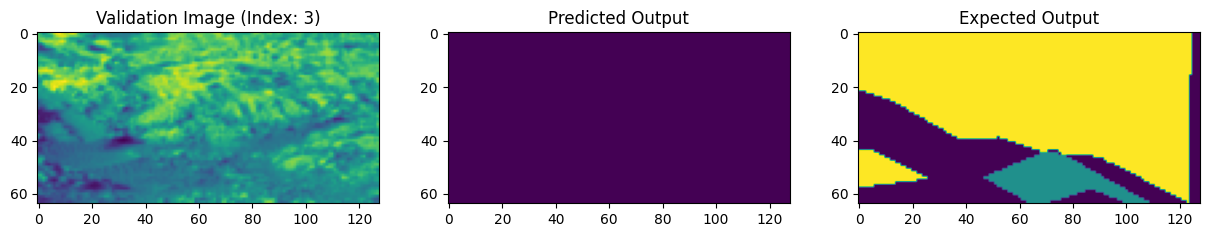

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - loss: 0.3518 - mean_io_u: 0.5724 - val_loss: 0.3339 - val_mean_io_u: 0.5845 - learning_rate: 1.0000e-05
Epoch 77/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - loss: 0.3338 - mean_io_u: 0.5802 - val_loss: 0.3261 - val_mean_io_u: 0.5894 - learning_rate: 1.0000e-05
Epoch 78/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3474 - mean_io_u: 0.5737 - val_loss: 0.3266 - val_mean_io_u: 0.5872 - learning_rate: 1.0000e-05
Epoch 79/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.3631 - mean_io_u: 0.5660 - val_loss: 0.3278 - val_mean_io_u: 0.5863 - learning_rate: 1.0000e-05
Epoch 80/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3273 - mean_io_u: 0.5866 - val_loss: 0.3287 - val_mean_io_u: 0.5868 - learning_rate: 1.0000e-05
Epoch 81/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 0.3322 - mean_io_u: 0.582


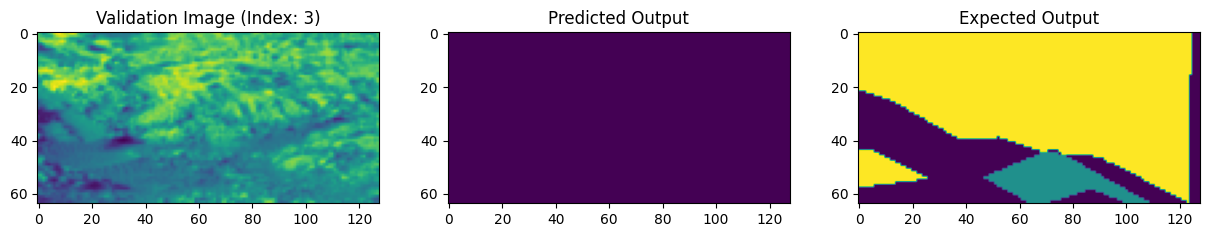

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - loss: 0.3321 - mean_io_u: 0.5825 - val_loss: 0.3220 - val_mean_io_u: 0.5890 - learning_rate: 1.0000e-05
Epoch 82/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3308 - mean_io_u: 0.5899 - val_loss: 0.3285 - val_mean_io_u: 0.5865 - learning_rate: 1.0000e-05
Epoch 83/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 0.3569 - mean_io_u: 0.5666 - val_loss: 0.3219 - val_mean_io_u: 0.5923 - learning_rate: 1.0000e-05
Epoch 84/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3470 - mean_io_u: 0.5775 - val_loss: 0.3247 - val_mean_io_u: 0.5889 - learning_rate: 1.0000e-05
Epoch 85/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - loss: 0.3459 - mean_io_u: 0.5784 - val_loss: 0.3203 - val_mean_io_u: 0.5925 - learning_rate: 1.0000e-05
Epoch 86/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - loss: 0.3343 - mean_io_u: 0.584


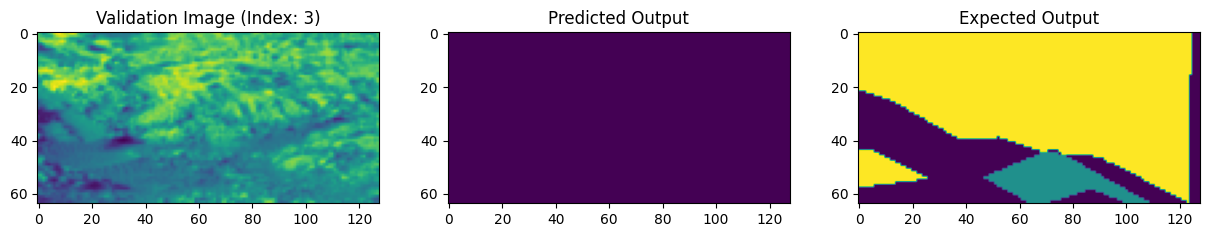

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - loss: 0.3346 - mean_io_u: 0.5843 - val_loss: 0.3220 - val_mean_io_u: 0.5913 - learning_rate: 1.0000e-05
Epoch 87/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.3195 - mean_io_u: 0.5905 - val_loss: 0.3245 - val_mean_io_u: 0.5871 - learning_rate: 1.0000e-05
Epoch 88/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.3267 - mean_io_u: 0.5776 - val_loss: 0.3313 - val_mean_io_u: 0.5859 - learning_rate: 1.0000e-05
Epoch 89/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.3394 - mean_io_u: 0.5795 - val_loss: 0.3247 - val_mean_io_u: 0.5898 - learning_rate: 1.0000e-05
Epoch 90/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.3235 - mean_io_u: 0.5887 - val_loss: 0.3250 - val_mean_io_u: 0.5901 - learning_rate: 1.0000e-05
Epoch 91/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/steptep - loss: 0.3322 - mean_io_u: 0.582


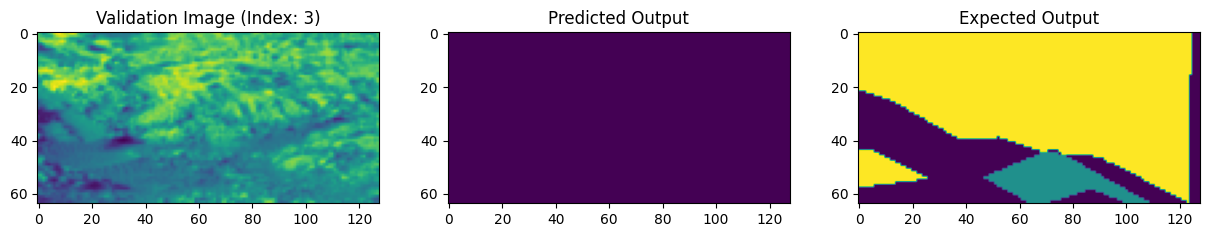

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - loss: 0.3324 - mean_io_u: 0.5823 - val_loss: 0.3300 - val_mean_io_u: 0.5846 - learning_rate: 1.0000e-05
Epoch 92/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3314 - mean_io_u: 0.5868 - val_loss: 0.3261 - val_mean_io_u: 0.5869 - learning_rate: 1.0000e-05
Epoch 93/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.3380 - mean_io_u: 0.5798 - val_loss: 0.3219 - val_mean_io_u: 0.5913 - learning_rate: 1.0000e-05
Epoch 94/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3198 - mean_io_u: 0.5889 - val_loss: 0.3249 - val_mean_io_u: 0.5899 - learning_rate: 1.0000e-05
Epoch 95/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3348 - mean_io_u: 0.5829 - val_loss: 0.3233 - val_mean_io_u: 0.5893 - learning_rate: 1.0000e-05
Epoch 96/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 0.3391 - mean_io_u: 0.589


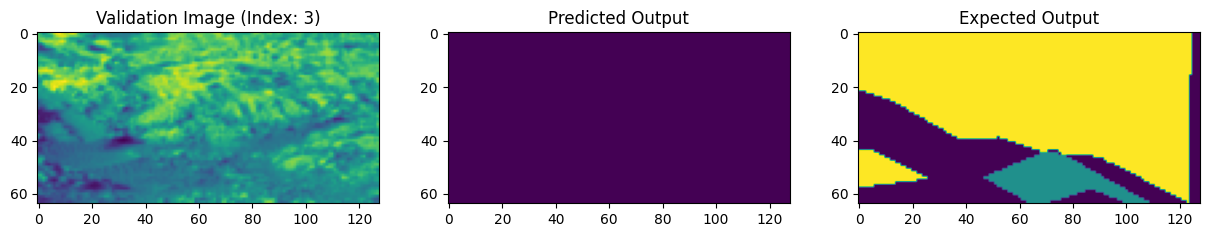

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - loss: 0.3391 - mean_io_u: 0.5894 - val_loss: 0.3272 - val_mean_io_u: 0.5836 - learning_rate: 1.0000e-05
Epoch 97/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - loss: 0.3401 - mean_io_u: 0.5757 - val_loss: 0.3298 - val_mean_io_u: 0.5858 - learning_rate: 1.0000e-05
Epoch 98/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - loss: 0.3327 - mean_io_u: 0.5967 - val_loss: 0.3252 - val_mean_io_u: 0.5887 - learning_rate: 1.0000e-05
Epoch 99/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3221 - mean_io_u: 0.6003 - val_loss: 0.3272 - val_mean_io_u: 0.5863 - learning_rate: 1.0000e-05
Epoch 100/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - loss: 0.3098 - mean_io_u: 0.5974 - val_loss: 0.3300 - val_mean_io_u: 0.5828 - learning_rate: 1.0000e-05
Epoch 101/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 0.3512 - mean_io_u: 0.571


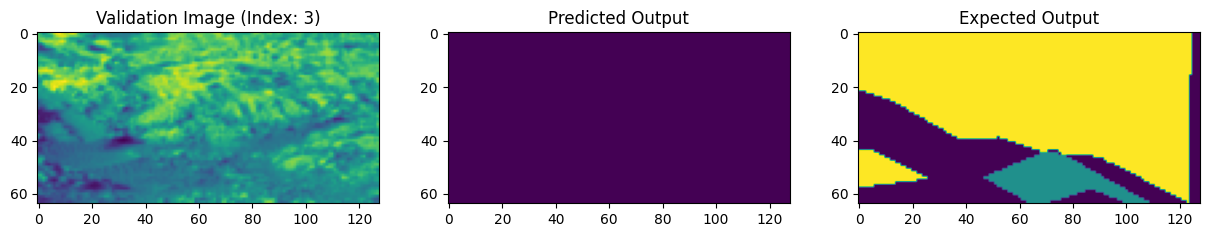

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - loss: 0.3506 - mean_io_u: 0.5714 - val_loss: 0.3267 - val_mean_io_u: 0.5828 - learning_rate: 1.0000e-05
Epoch 102/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 0.3262 - mean_io_u: 0.5952 - val_loss: 0.3294 - val_mean_io_u: 0.5868 - learning_rate: 1.0000e-05
Epoch 103/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 0.3498 - mean_io_u: 0.5788 - val_loss: 0.3232 - val_mean_io_u: 0.5873 - learning_rate: 1.0000e-05
Epoch 104/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3433 - mean_io_u: 0.5760 - val_loss: 0.3304 - val_mean_io_u: 0.5817 - learning_rate: 1.0000e-05
Epoch 105/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.3117 - mean_io_u: 0.5953 - val_loss: 0.3255 - val_mean_io_u: 0.5863 - learning_rate: 1.0000e-05
Final validation Mean Intersection Over Union: 59.25%


In [ ]:
train_gen = data_generator(X_train, y_train, batch_size, transform)

# Train the model
history = model.fit(
    train_gen,
    batch_size=batch_size,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, redurce_learning_rate, visualize],
).history

# Calculate and print the final validation mean IoU
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# 🛟 Save the model

In [ ]:
model_filename = f"weights.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to weights.keras


# 📈 Plot loss and mean IoU

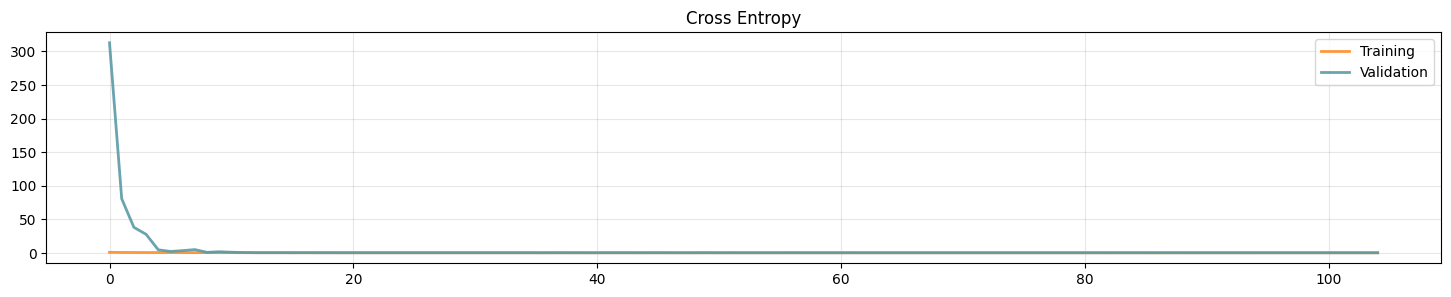

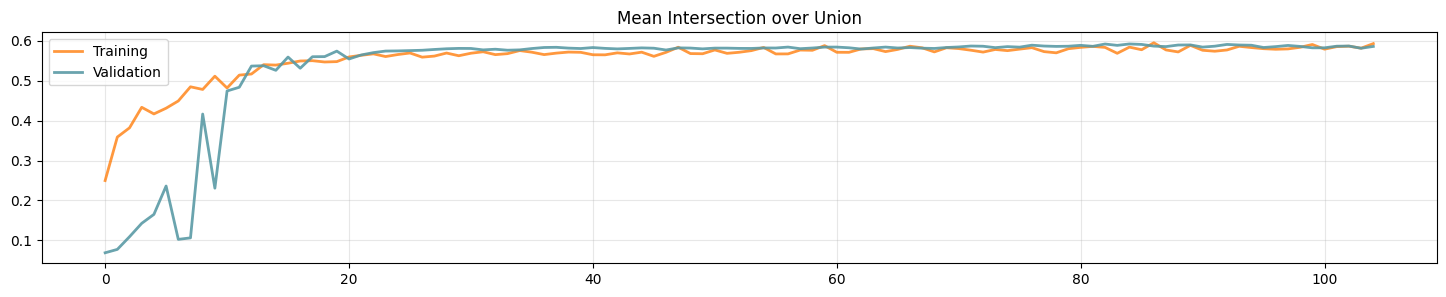

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()